In [1]:
import os
import librosa
import scipy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA,KernelPCA
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

### 1.查看音频数据集的内容

----One classified dataset numbers: 150
----Total audio classes numbers: 5
----Total audio labels: ['起飞', '降落', '前进', '后退', '升高']


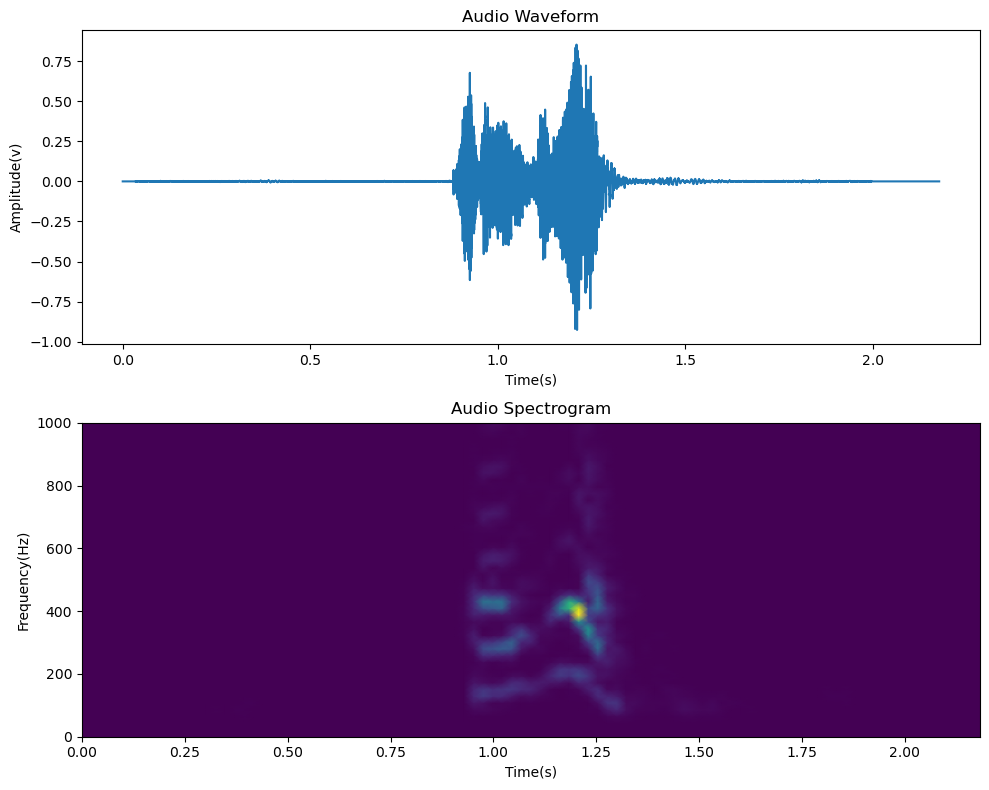

In [12]:
# 定义数据集路径以及标签
Audio_Data_Path=r'..\dataset\train_set'
labels=['起飞','降落','前进','后退','升高']
labels_dict={'起飞':0,'降落':1,'前进':2,'后退':3,'升高':4}
one_class_num=len(os.listdir(os.path.join(Audio_Data_Path,labels[0])))
print(f'----One classified dataset numbers: {len(os.listdir(os.path.join(Audio_Data_Path,labels[0])))}')
print(f'----Total audio classes numbers: {len(os.listdir(Audio_Data_Path))}')
print(f'----Total audio labels: {labels}')

def audio_plot(audio_path,sr=16000):
    '''绘制时域波形和频谱波形'''
    waveform,sr=librosa.load(audio_path)
    fig,ax=plt.subplots(2,1,figsize=(10,8))
    ax[0].plot(np.linspace(0,len(waveform)/sr,len(waveform)),waveform)
    ax[0].set_title('Audio Waveform')
    ax[0].set_xlabel('Time(s)')
    ax[0].set_ylabel('Amplitude(v)')
    
    freq,t,Zxx=scipy.signal.stft(waveform,fs=sr,nperseg=1024)
    ax[1].pcolormesh(t,freq,np.abs(Zxx),shading='gouraud')
    ax[1].set_title('Audio Spectrogram')
    ax[1].set_xlabel('Time(s)')
    ax[1].set_ylabel('Frequency(Hz)')
    ax[1].set_ylim(0,1000)
    fig.tight_layout()
    
audio_path=os.path.join(Audio_Data_Path,labels[2],'3.wav')
audio_plot(audio_path)

### 2.提取语音指令的MFCC特征

In [13]:
# 设置mfcc的参数
num_mfcc_features=25

def mfcc_extraction(audio_dir,labels):
    '''提取mfcc的mean,std,var,min,max,label特征'''
    mean_features=[]
    std_features=[]
    var_features=[]
    min_features=[]
    max_features=[]
    label_features=[]
    for file in os.listdir(audio_dir):
        file_path=os.path.join(audio_dir,file)
        # label= labels_dict[file]
        label=file
        for file_name in tqdm(os.listdir(file_path),desc='----'+file):
            audio_path=os.path.join(file_path,file_name)
            waveform,sr=librosa.load(audio_path)
            mean_features.append(np.mean(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=num_mfcc_features).T,axis=0))
            std_features.append(np.std(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=num_mfcc_features).T,axis=0))
            var_features.append(np.var(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=num_mfcc_features).T,axis=0))
            min_features.append(np.min(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=num_mfcc_features).T,axis=0))
            max_features.append(np.max(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=num_mfcc_features).T,axis=0))
            label_features.append(label)
    return mean_features,std_features,var_features,min_features,max_features,label_features

mfcc_features_labels=mfcc_extraction(Audio_Data_Path,labels)
print(f'----特征提取完毕')


----降落: 100%|██████████| 150/150 [00:03<00:00, 42.73it/s]

----特征提取完毕


### 3.应用主成分分析PCA

----Length of examples: 750
----Length of lanels: 750
----Number of mfcc features: 25
----Feature dimension: 1
----Feature shape: (25,)
----MFCC features shape: (750, 125)


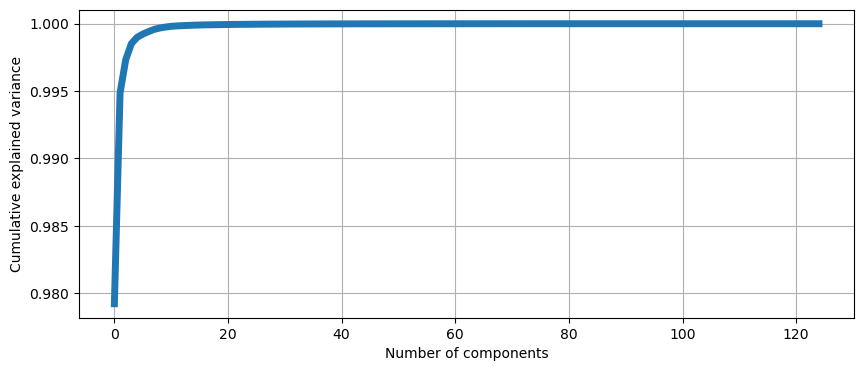

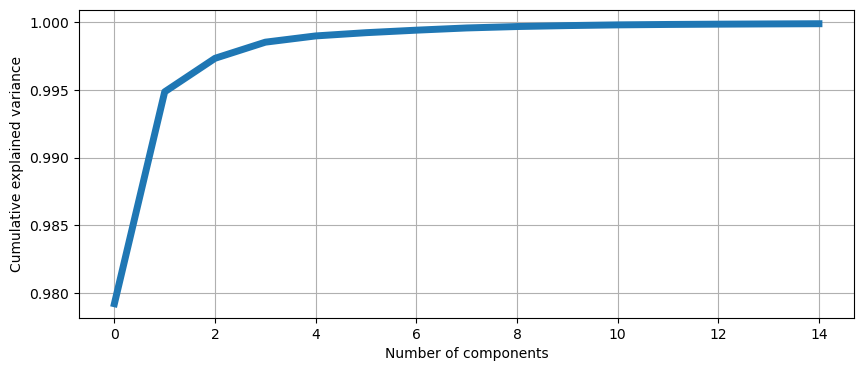

----PCA MFCC feature shape: (750, 15)
----PCA explained variance ratio shape: (15,)
----Normal MFCC feature shape: (750, 15)


In [7]:
mean_mfcc,std_mfcc,var_mfcc,min_mfcc,max_mfcc,label_mfcc=mfcc_features_labels
print(f'----Length of examples: {len(mean_mfcc)}')
print(f'----Length of lanels: {len(label_mfcc)}')
print(f'----Number of mfcc features: {num_mfcc_features}')
print(f'----Feature dimension: {mean_mfcc[0].ndim}')
print(f'----Feature shape: {mean_mfcc[0].shape}')

# 特征连接
mfcc_feature=np.concatenate((mean_mfcc,std_mfcc,var_mfcc,min_mfcc,max_mfcc),axis=1)
print(f'----MFCC features shape: {mfcc_feature.shape}')

# 应用pca,mfcc_feature-行:样本数,列：mfcc特征量
def PCA_plot(pca):
    plt.figure(figsize=(10,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth=5) # 解释方差比
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance') # 累积解释方差
    plt.grid(True)
    plt.box(True)
    plt.show()
pca=PCA().fit(mfcc_feature)
PCA_plot(pca)

# PCA降维到人工设置维数n_components
n_components=15
pca=PCA(n_components=n_components)
PCA_plot(pca.fit(mfcc_feature))
mfcc_feature_pca=pca.fit_transform(mfcc_feature)
print(f'----PCA MFCC feature shape: {mfcc_feature_pca.shape}')
print(f'----PCA explained variance ratio shape: {pca.explained_variance_ratio_.shape}')
# 数据mfcc标准化
mfcc_feature_normal=StandardScaler().fit_transform(mfcc_feature_pca)
print(f'----Normal MFCC feature shape: {mfcc_feature_normal.shape}')
# print(f'---MFCC Labels: {label_mfcc}')

### 4.过采样中性数据以匹配我们的数据集

In [14]:
dictionary={}
for i in label_mfcc:
    dictionary[i]=dictionary.get(i,0)+1
print(f'----Dictionary labels: {dictionary}')

# 过采样中性数据
new_mfcc_feature,mfcc_label=RandomOverSampler(random_state=42).fit_resample(mfcc_feature_normal,label_mfcc)
dictionary_new={}
for i in mfcc_label:
    dictionary_new[i]=dictionary_new.get(i,0)+1
print(f'----New dictionary labels: {dictionary_new}')
print(f'----MFCC feature shape: {mfcc_feature_normal.shape}')
print(f'----New mfcc feature shape: {new_mfcc_feature.shape}')   
new_mfcc_label=[]
for label in mfcc_label:
    if label=='起飞':
        new_mfcc_label.append(labels_dict['起飞'])
    elif label=='降落':
        new_mfcc_label.append(labels_dict['降落'])
    elif label=='前进':
        new_mfcc_label.append(labels_dict['前进'])
    elif label=='后退':
        new_mfcc_label.append(labels_dict['后退'])
    elif label=='升高':
        new_mfcc_label.append(labels_dict['升高'])
print(f'----New mfcc label: {np.array(new_mfcc_label).shape}')
# print(f'----MFCC label: {mfcc_label}')

----Dictionary labels: {'前进': 150, '升高': 150, '后退': 150, '起飞': 150, '降落': 150}
----New dictionary labels: {'前进': 150, '升高': 150, '后退': 150, '起飞': 150, '降落': 150}
----MFCC feature shape: (750, 15)
----New mfcc feature shape: (750, 15)
----New mfcc label: (750,)


### 5.支持向量机SVM模型

----Accuracy Score: 87.61%
----Classification report: 
              precision    recall  f1-score   support

          前进       0.80      0.87      0.83        23
          升高       0.90      0.86      0.88        22
          后退       0.92      0.96      0.94        23
          起飞       0.86      0.78      0.82        23
          降落       0.91      0.91      0.91        22

    accuracy                           0.88       113
   macro avg       0.88      0.88      0.88       113
weighted avg       0.88      0.88      0.88       113



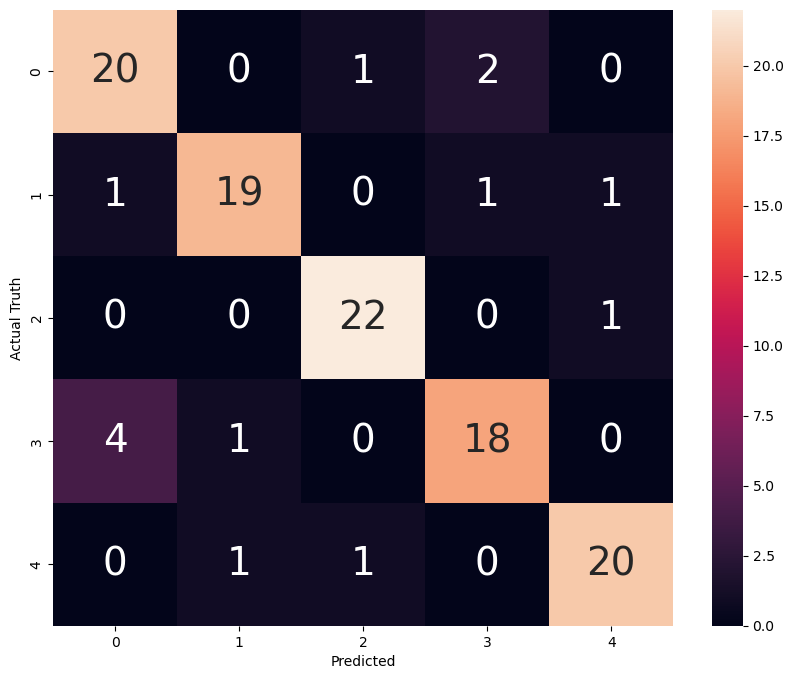

In [15]:
X_train,X_test,y_train,y_test=train_test_split(new_mfcc_feature,mfcc_label,test_size=0.15,random_state=42,stratify=mfcc_label,shuffle=True)
clf=SVC(C=5,gamma=0.09,kernel='rbf')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
-
def confusion_matrix_plot(confusion_matrix,xlabel='Predicted'):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix,annot=True,fmt='d',annot_kws={"size":28})
    plt.xlabel(xlabel)
    plt.ylabel('Actual Truth')

print(f'----Accuracy Score: {accuracy_score(y_test,y_pred)*100:.2f}%')
print(f'----Classification report: \n{classification_report(y_test,y_pred)}')
confusion_matrix_plot(confusion_matrix(y_test,y_pred))

### 6.使用网格搜索优化模型

----Best parameters: {'C': 2, 'gamma': 0.095, 'kernel': 'rbf'}
----Best estimator: SVC(C=2, gamma=0.095)
----Accuracy: 80.53%
----Classification report: 
              precision    recall  f1-score   support

          前进       0.69      0.87      0.77        23
          升高       0.83      0.86      0.84        22
          后退       0.86      0.78      0.82        23
          起飞       0.81      0.74      0.77        23
          降落       0.89      0.77      0.83        22

    accuracy                           0.81       113
   macro avg       0.82      0.81      0.81       113
weighted avg       0.81      0.81      0.81       113



(None,)

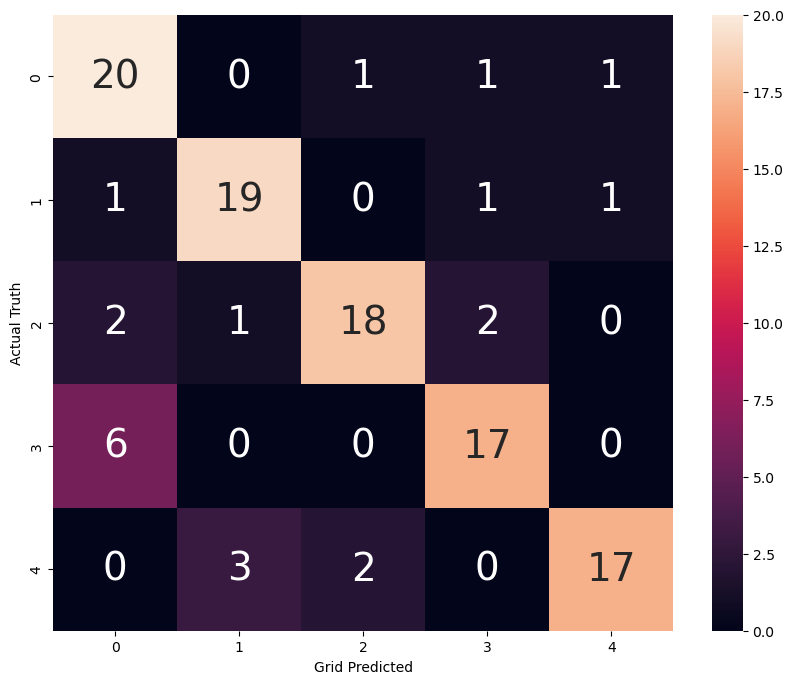

In [11]:
param_grid={'C':[1,2,3,4,5],
            'gamma':[0.08,0.085,0.09,0.095,0.1,0.15],
            'kernel':['linear','rbf','poly']}
grid=GridSearchCV(SVC(),param_grid,cv=6)
grid.fit(X_train,y_train)
print(f'----Best parameters: {grid.best_params_}')
print(f'----Best estimator: {grid.best_estimator_}')

# 预测结果
grid_pred=grid.predict(X_test)
print(f'----Accuracy: {accuracy_score(y_test,grid_pred)*100:.2f}%')
print(f'----Classification report: \n{classification_report(y_test,grid_pred)}')
confusion_matrix_plot(confusion_matrix(y_test,grid_pred),xlabel='Grid Predicted'),

### 7.保存模型，加载小测试

In [29]:
import pickle
with open('audio_mfcc_svm_classifier.pkl','wb') as model_file:
    pickle.dump(clf,model_file)
print('----模型保存完毕')


# # 加载测试
# with open('audio_mfcc_svm_classifier.pkl','rb') as model_file:
#     model=pickle.load(model_file)

# def Audio_Processor(audio_path):
#     waveform,sr=librosa.load(audio_path)
#     n_mfcc,n_components=25,15
#     f_mean=np.mean(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=n_mfcc).T,axis=0)
#     f_std=np.std(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=n_mfcc).T,axis=0)
#     f_var=np.var(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=n_mfcc).T,axis=0)
#     f_min=np.min(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=n_mfcc).T,axis=0)
#     f_max=np.max(librosa.feature.mfcc(y=waveform,sr=sr,n_mfcc=n_mfcc).T,axis=0)
#     mfcc_test=np.concatenate((f_mean,f_std,f_var,f_min,f_max))
#     mfcc_test=np.expand_dims(mfcc_test,axis=0)
#     mfcc_test=np.tile(mfcc_test,(n_components,1))
#     print(f'----MFCC Test shape: {mfcc_test.shape}')
#     mfcc_test_pca=PCA(n_components=n_components).fit_transform(mfcc_test)
#     mfcc_test_normal=StandardScaler().fit_transform(mfcc_test_pca)
#     return mfcc_test_normal[0]

# test_audio_path=r'..\dataset\train_set\降落\5.wav'
# mfcc=Audio_Processor(test_audio_path)
# mfcc=np.expand_dims(mfcc,axis=0)
# result=model.predict(mfcc)
# print(f'----Test audio shape: {mfcc.shape}')
# print(f'----Model predicted result: {result[0]}')

----模型保存完毕
----MFCC Test shape: (15, 125)
----Test audio shape: (1, 15)
----Model predicted result: 降落
